# Weight Watchers

# Preliminary analysis of extracted convolutional layers

### includes auto MP fits and mp soft ranks



In [22]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn

import numpy as np
import powerlaw
import tensorflow as tf

import sklearn
from sklearn.decomposition import TruncatedSVD

from tqdm import tqdm_notebook as tqdm

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import import_ipynb
import RMT_Util

importing notebook from RMT_Util.ipynb


/Users/charlesmartin14/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charlesmartin14/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.14.2
scipy version 1.0.1
tensforflow version 1.5.0-dev20171116
keras version 2.2.2
sklearn version 0.19.1
powerlaw version 1.4.3


In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,5]

In [27]:
from keras.models import load_model
from keras.applications import vgg16
from keras.models import model_from_json

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
#model = load_model('model.h5')
kmodel = vgg16.VGG16
model = kmodel(weights="imagenet")

In [28]:
kmodel

<function keras_applications.vgg16.VGG16>

In [18]:
model

In [19]:
model.save("kerasmodel.h5")

In [25]:
for i,layer in enumerate(model.layers):
    print(i, layer)

0 <keras.engine.input_layer.InputLayer object at 0x13bd74f28>
1 <keras.layers.convolutional.Conv2D object at 0x11acf1470>
2 <keras.layers.convolutional.Conv2D object at 0x13bd7c0f0>
3 <keras.layers.pooling.MaxPooling2D object at 0x11af60898>
4 <keras.layers.convolutional.Conv2D object at 0x11afd3550>
5 <keras.layers.convolutional.Conv2D object at 0x11afcb128>
6 <keras.layers.pooling.MaxPooling2D object at 0x10d754fd0>
7 <keras.layers.convolutional.Conv2D object at 0x11e469780>
8 <keras.layers.convolutional.Conv2D object at 0x11e47c860>
9 <keras.layers.convolutional.Conv2D object at 0x11e4a7b70>
10 <keras.layers.pooling.MaxPooling2D object at 0x11e4cf780>
11 <keras.layers.convolutional.Conv2D object at 0x11e4e7908>
12 <keras.layers.convolutional.Conv2D object at 0x11e4fd908>
13 <keras.layers.convolutional.Conv2D object at 0x11e528320>
14 <keras.layers.pooling.MaxPooling2D object at 0x11e53fef0>
15 <keras.layers.convolutional.Conv2D object at 0x11e5546a0>
16 <keras.layers.convolutional.C

In [26]:
W=layer.get_weights()[0]

FailedPreconditionError: Attempting to use uninitialized value predictions_1/bias
	 [[Node: _retval_predictions_1/bias_0_0 = _Retval[T=DT_FLOAT, index=0, _device="/job:localhost/replica:0/task:0/device:CPU:0"](predictions_1/bias)]]

### All Linear Models

In [4]:
def list_layers(model
               ):
    pretrained_model = model(pretrained=True)
    
    model_name = model.__name__
    model_name = model_name.replace("_",' ')
    alphas = []
    soft_ranks = []
    
    for im, m in enumerate(pretrained_model.modules()):
        #print(im,m)
        if  isinstance(m, nn.Linear):     
            W = np.array(m.weight.data.clone().cpu())
            if W is not None:
                print(im,m, W.shape)
        elif isinstance(m, nn.Conv2d):
            #print("conv2d")
            Wtensor = np.array(m.weight.data.clone().cpu())
            Wmats = get_conv2D_Wmats(Wtensor)
            print(im,m)
            for W in Wmats:
                print(W.shape)
        
        

In [5]:
def get_conv2D_Wmats(Wtensor):
    """Extract W slices from a 4 index conv2D tensor of shape: (N,M,i,j) or (M,N,i,j).  Return ij (N x M) matrices"""
    Wmats = []
    s = Wtensor.shape
    N, M, imax, jmax = s[0],s[1],s[2],s[3]
    print("tensor shape", N,M,imax,jmax)
    for i in range(imax):
        for j in range(jmax):
            W = Wtensor[:,:,i,j]
            if N < M:
                W = W.T
            Wmats.append(W)
    return Wmats

In [8]:
def analyze_model(model, linear=False, conv2d=True, plot=True):
    pretrained_model = model(pretrained=True)
    
    model_name = model.__name__
    model_name = model_name.replace("_",' ')
    alphas = []
    soft_ranks = []
    min_svs = []

    for im, m in enumerate(pretrained_model.modules()):
        Wmats = []
        #print(im, isinstance(m, nn.Conv2d))
        if linear and isinstance(m, nn.Linear):     
            W = np.array(m.weight.data.clone().cpu())
            Wmats = [W]
        elif conv2d and isinstance(m, nn.Conv2d):
            #print("conv2d")
            Wtensor = np.array(m.weight.data.clone().cpu())
            Wmats = get_conv2D_Wmats(Wtensor)
            
        #print("num mats ",len(Wmats))
        if Wmats is not None and len(Wmats)>0:
            for W in Wmats:
                #print(W.shape)

                M, N = np.min(W.shape), np.max(W.shape)
                Q=N/M 
                if M > 49:
                    sv, _ = RMT_Util.singular_spectrum(W)  # np.linalg.svd
                    evals = sv*sv
                    plt.hist(evals, bins=100, density=True)
                    plt.show()
                    #scaled_evals = (1/N)*evals
                    # RMT_Util.fit_power_law
                    
                    fit = powerlaw.Fit(evals, xmax=np.max(evals), verbose=False)  
                    alpha = fit.alpha
                    print(alpha)
                    D = fit.D

                    dist = RMT_Util.best_dist(fit) #later
                    sigma = RMT_Util.fit_mp(evals, Q) # later
                    mp_soft_rank = RMT_Util.calc_mp_soft_rank(evals,Q,sigma) #later

                    min_svs.append(np.min(sv)) # minimum singular value

                    alphas.append(alpha)
                    soft_ranks.append(mp_soft_rank) #later
    return alphas, soft_ranks, min_svs


tensor shape 64 3 3 3
tensor shape 128 64 3 3


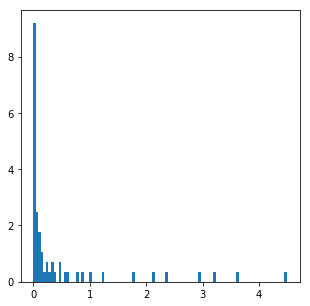

/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


1.6501381932727157


Assuming nested distributions
RMT_Util.ipynb:6: RuntimeWarning: divide by zero encountered in true_divide
  "source": [
RMT_Util.ipynb:6: RuntimeWarning: invalid value encountered in sqrt
  "source": [


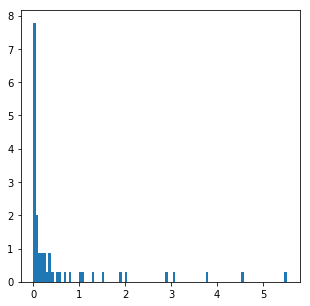

1.5729749415362662


Assuming nested distributions


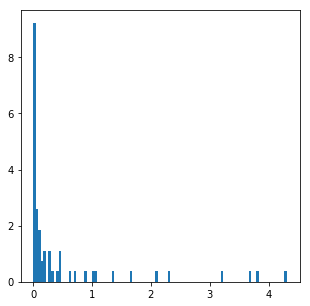

1.412103862784683


Assuming nested distributions


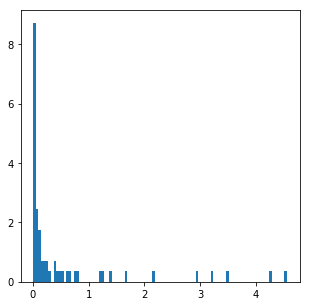

1.4345911693891173


Assuming nested distributions


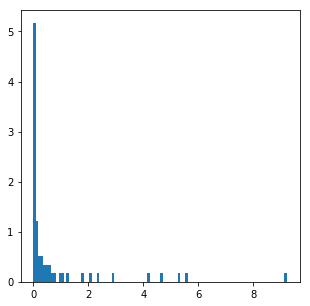

1.6184989544962864


Assuming nested distributions


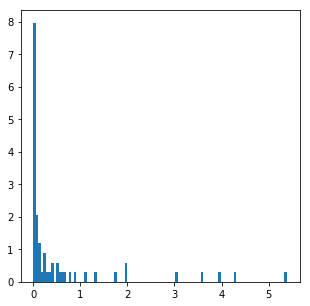

1.3854857065038901


Assuming nested distributions


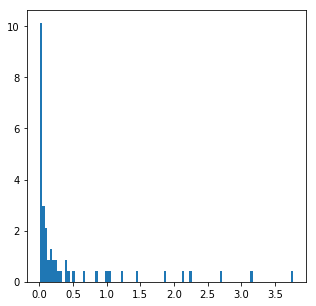

1.5692041424503356


Assuming nested distributions


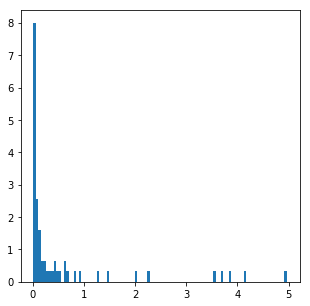

1.4466120520491108


Assuming nested distributions


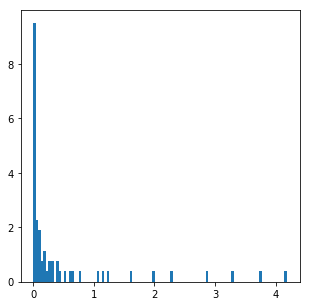

1.613618880148302


Assuming nested distributions


tensor shape 256 128 3 3


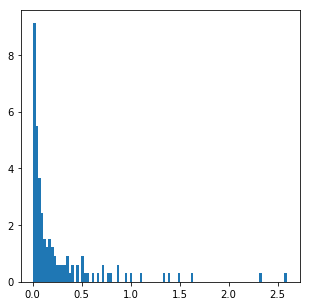

2.6822103125188894


Assuming nested distributions


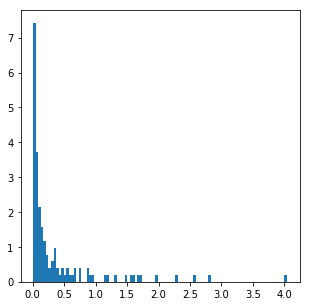

1.6245754293902


Assuming nested distributions


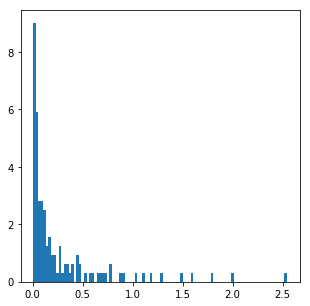

1.7481681153395097


Assuming nested distributions


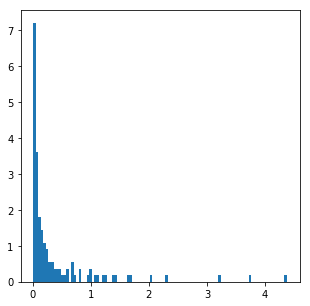

2.5760770099650085


Assuming nested distributions


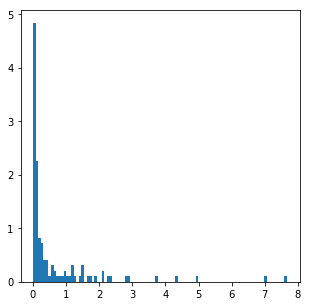

2.5337252827134855


Assuming nested distributions


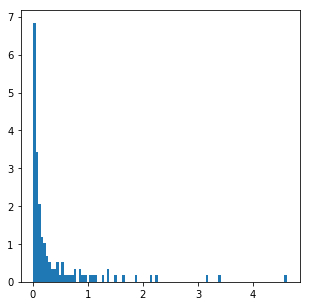

1.6150836542197298


Assuming nested distributions


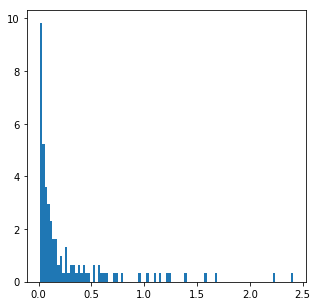

1.6649285898285484


Assuming nested distributions


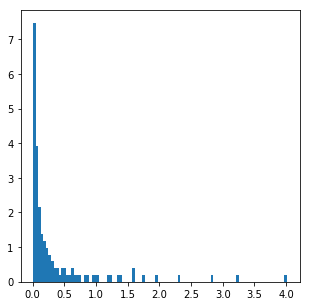

1.691165177455313


Assuming nested distributions


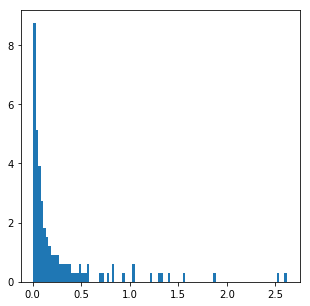

2.0503675994957917


Assuming nested distributions


tensor shape 256 256 3 3


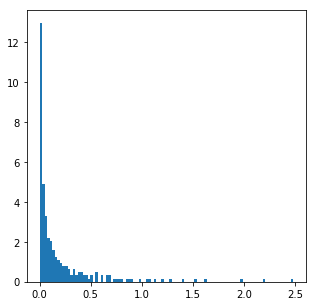

2.2103687177518347


Assuming nested distributions
RMT_Util.ipynb:6: RuntimeWarning: invalid value encountered in multiply
  "source": [


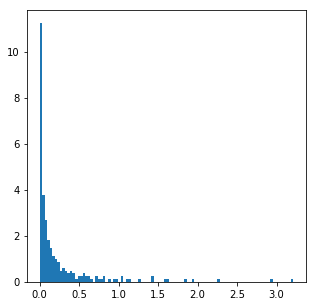

2.025263706050683


Assuming nested distributions


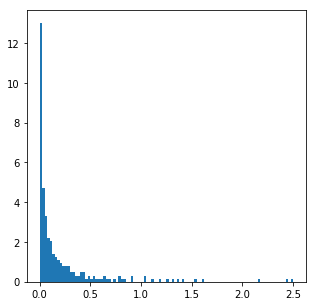

2.0484481956732847


Assuming nested distributions


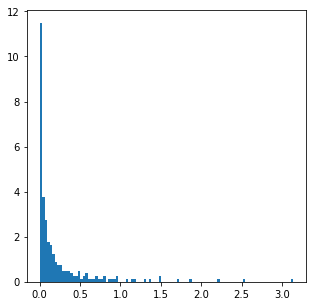

2.658269404138535


Assuming nested distributions


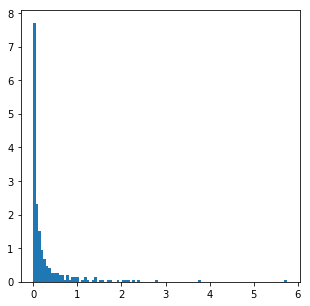

1.8004537204130642


Assuming nested distributions


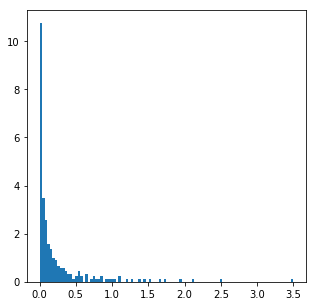

2.042517042427739


Assuming nested distributions


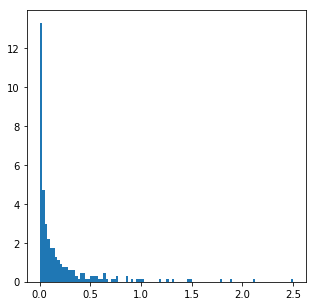

2.604095613159342


Assuming nested distributions


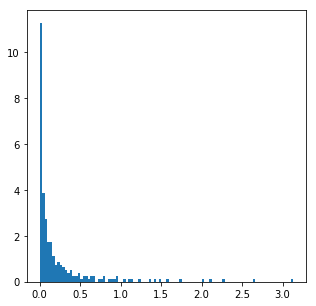

1.9744266754704936


Assuming nested distributions


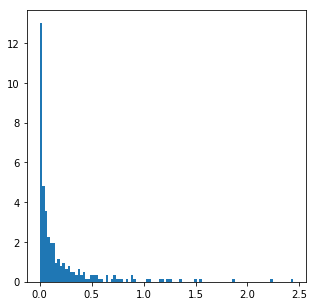

2.0731955566531513


Assuming nested distributions


tensor shape 512 256 3 3


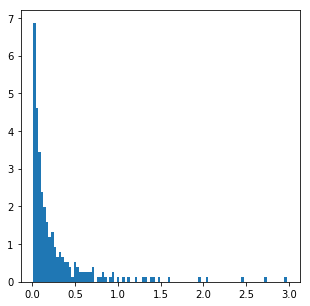

2.651723638615695


Assuming nested distributions


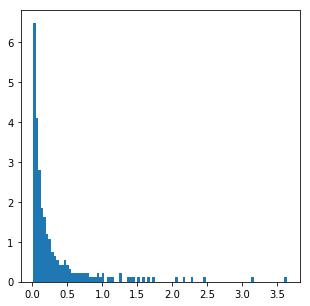

2.1681140785288173


Assuming nested distributions


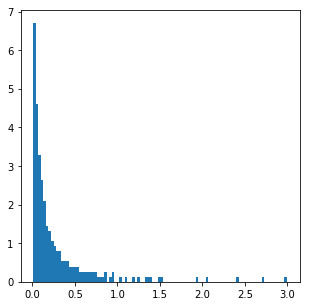

2.689082314155521


Assuming nested distributions


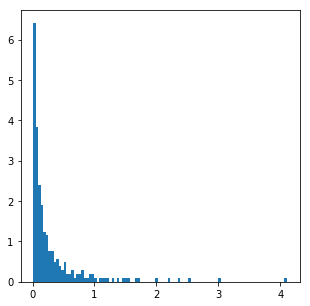

2.0557194779132395


Assuming nested distributions


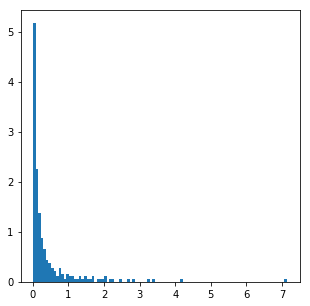

3.824145157092213


Assuming nested distributions
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/powerlaw.py:1602: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


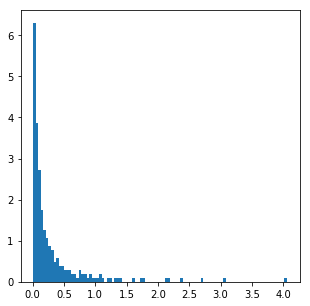

2.8416604636144407


Assuming nested distributions


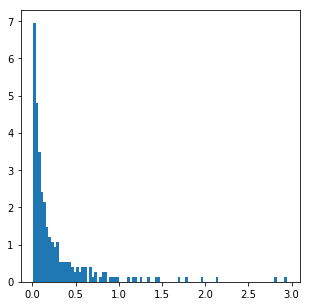

2.5426601230212116


Assuming nested distributions


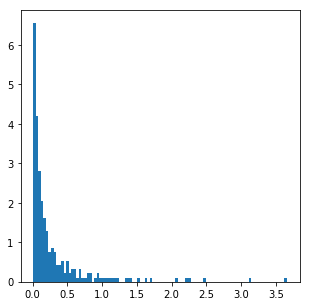

2.8994881224684304


Assuming nested distributions


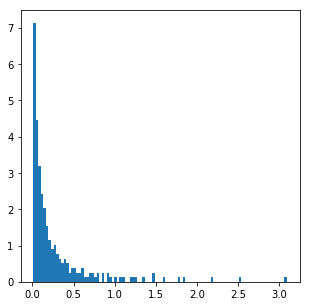

2.2671617870055316


Assuming nested distributions


tensor shape 512 512 3 3


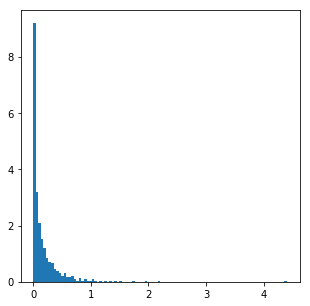

KeyboardInterrupt: 

In [9]:
for model in [models.vgg11]:
    analyze_model(model)

### PoweLaw fit for all FC and CNN layers

In [7]:
all_alphas, all_ranks, all_min_svs = [], [], []
for model in tqdm([models.alexnet, 
              models.densenet121, models.densenet161, models.densenet169, models.densenet201, 
              models.inception_v3,
              models.resnet101, models.resnet152, models.resnet18, models.resnet34, models.resnet50, 
              models.squeezenet1_0, models.squeezenet1_1,
              models.vgg11, models.vgg11_bn,
              models.vgg16, models.vgg16_bn,
              models.vgg19, models.vgg19_bn ]):
    #print(model)
    #analyze_model(model, conv2d=True, plot=False)
    alphas, soft_ranks, min_svs = analyze_model(model)
    all_alphas.extend(alphas)
    all_ranks.extend(soft_ranks)
    all_min_svs.extend(min_svs)

tensor shape 64 3 11 11
tensor shape 192 64 5 5


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Assuming nested distributions
RMT_Util.ipynb:6: RuntimeWarning: divide by zero encountered in true_divide
  "source": [
RMT_Util.ipynb:6: RuntimeWarning: invalid value encountered in sqrt
  "source": [
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distr

tensor shape 384 192 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 384 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
RMT_Util.ipynb:6: RuntimeWarning: invalid value encountered in multiply
  "source": [
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are

tensor shape 64 3 7 7
tensor shape 128 64 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 96 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 128 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 160 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 192 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 224 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 256 1 1


Assuming nested distributions


tensor shape 128 128 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 160 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 192 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 224 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 256 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 288 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 320 1 1
tensor shape 32 128 3 3
tensor shape 128 352 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 384 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 416 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 448 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 480 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 256 512 1 1


Assuming nested distributions


tensor shape 128 256 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 288 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 320 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 352 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 384 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 416 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 448 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 480 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 544 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 576 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 608 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 640 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 672 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 704 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 736 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 768 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 800 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 832 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 864 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 896 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 928 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 960 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 992 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 512 1024 1 1


Assuming nested distributions


tensor shape 128 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 544 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 576 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 608 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 640 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 672 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 704 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 736 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 800 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 832 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 864 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 896 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 928 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 960 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 992 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 96 3 7 7
tensor shape 192 96 1 1
tensor shape 48 192 3 3
tensor shape 192 144 1 1


Assuming nested distributions
Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 192 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 240 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 288 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 336 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 384 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 192 192 1 1


Assuming nested distributions
Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 240 1 1
tensor shape 48 192 3 3
tensor shape 192 288 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 336 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 384 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 432 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 480 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 528 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 576 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 624 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 672 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 720 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 384 768 1 1


Assuming nested distributions


tensor shape 192 384 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 432 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 480 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 528 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 576 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 624 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 672 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 720 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 768 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 816 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 864 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 912 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 960 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1008 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1056 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1104 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1152 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1200 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1248 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1296 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1344 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1392 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1440 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1488 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1536 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1584 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1632 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1680 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1728 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1776 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1824 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1872 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1920 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1968 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 2016 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 2064 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 1056 2112 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 192 1056 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1104 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1152 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1200 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1248 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1296 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1344 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1392 1 1


Assuming nested distributions


tensor shape 48 192 3 3
tensor shape 192 1440 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1488 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1536 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1584 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1632 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1680 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1728 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1776 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1824 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1872 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1920 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 1968 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 2016 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 2064 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 2112 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 192 2160 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 48 192 3 3
tensor shape 64 3 7 7
tensor shape 128 64 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 96 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 128 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 160 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 192 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 224 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 256 1 1


Assuming nested distributions


tensor shape 128 128 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 160 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 192 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 224 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 256 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 288 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 320 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 352 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 384 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 416 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 448 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 480 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 256 512 1 1


Assuming nested distributions


tensor shape 128 256 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 288 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 320 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 352 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 384 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 416 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 448 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 480 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 544 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 576 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 608 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 640 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 672 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 704 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 736 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 800 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 832 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 864 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 896 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 928 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 960 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 992 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1024 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1056 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1088 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1120 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1152 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1184 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1216 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1248 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 640 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 128 640 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 672 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 704 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 736 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 768 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 800 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 832 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 864 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 896 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 928 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 960 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 992 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1024 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1056 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1088 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1120 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1152 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1184 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1216 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1248 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1312 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1344 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1376 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1408 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1440 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1472 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1504 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1536 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1568 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1600 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1632 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 64 3 7 7
tensor shape 128 64 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 96 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 128 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 160 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 192 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 224 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 256 1 1


Assuming nested distributions


tensor shape 128 128 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 160 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 192 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 224 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 288 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 320 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 352 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 384 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 416 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 448 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 480 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 256 512 1 1


Assuming nested distributions


tensor shape 128 256 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 288 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 320 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 352 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 384 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 416 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 448 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 480 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 544 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 576 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 608 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 640 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 672 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 704 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 736 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 768 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 800 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 832 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 864 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 896 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 928 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 960 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 992 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1024 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1056 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1088 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1120 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1152 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1184 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1216 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1248 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1280 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1312 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1344 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1376 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1408 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1440 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1472 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1504 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1536 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1568 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1600 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1632 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1664 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1696 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1728 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1760 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 896 1792 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 128 896 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 928 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 960 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 992 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1024 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1056 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1088 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1120 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1152 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1184 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1216 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1248 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1312 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1344 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1376 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1408 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1440 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1472 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1504 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1536 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1568 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1600 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1632 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1664 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1696 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 128 1728 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1760 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1792 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1824 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1856 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 32 128 3 3
tensor shape 128 1888 1 1


Assuming nested distributions


tensor shape 32 128 3 3
tensor shape 32 3 3 3
tensor shape 32 32 3 3
tensor shape 64 32 3 3
tensor shape 80 64 1 1


Assuming nested distributions


tensor shape 192 80 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 192 1 1


Assuming nested distributions


tensor shape 48 192 1 1
tensor shape 64 48 5 5
tensor shape 64 192 1 1


Assuming nested distributions


tensor shape 96 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 96 96 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 32 192 1 1
tensor shape 64 256 1 1
tensor shape 48 256 1 1
tensor shape 64 48 5 5
tensor shape 64 256 1 1


Assuming nested distributions
Assuming nested distributions


tensor shape 96 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 96 96 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 256 1 1
tensor shape 64 288 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 48 288 1 1
tensor shape 64 48 5 5
tensor shape 64 288 1 1


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 96 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 96 96 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 288 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 384 288 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 288 1 1


Assuming nested distributions
Assuming nested distributions


tensor shape 96 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 96 96 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 768 1 1


Assuming nested distributions


tensor shape 128 768 1 1


Assuming nested distributions


tensor shape 128 128 1 7


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 128 7 1


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 768 1 1


Assuming nested distributions


tensor shape 128 128 7 1


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 1 7


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 7 1


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 128 1 7


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 768 1 1


Assuming nested distributions


tensor shape 192 768 1 1


Assuming nested distributions


tensor shape 160 768 1 1


Assuming nested distributions


tensor shape 160 160 1 7


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 160 7 1


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 160 768 1 1


Assuming nested distributions


tensor shape 160 160 7 1


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 160 160 1 7


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 160 160 7 1


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 160 1 7


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 768 1 1


Assuming nested distributions


tensor shape 192 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 160 768 1 1


Assuming nested distributions


tensor shape 160 160 1 7


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 160 7 1


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 160 768 1 1


Assuming nested distributions


tensor shape 160 160 7 1


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 160 160 1 7


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 160 160 7 1


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 160 1 7


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 768 1 1


Assuming nested distributions


tensor shape 192 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 192 768 1 1


Assuming nested distributions


tensor shape 192 192 1 7


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 192 7 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 192 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 192 192 7 1


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 192 1 7


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 192 7 1


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 192 192 1 7


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested di

tensor shape 192 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 128 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 768 128 5 5


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 192 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 320 192 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 192 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 192 192 1 7


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 192 7 1


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 192 192 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 320 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 384 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 384 384 1 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 384 384 3 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 448 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 384 448 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calc

tensor shape 384 384 1 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 384 384 3 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 192 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 320 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 384 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 384 384 1 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 384 384 3 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 448 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 384 448 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 384 384 1 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 384 384 3 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 192 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 64 3 7 7
tensor shape 64 64 1 1
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 64 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 64 1 1
tensor shape 64 256 1 1


Assuming nested distributions
Assuming nested distributions


tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 64 1 1
tensor shape 64 256 1 1
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 64 1 1


Assuming nested distributions


tensor shape 128 256 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 512 256 1 1


Assuming nested distributions


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 256 512 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 1024 512 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 512 1024 1 1


Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 2048 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 2048 1024 1 1


Assuming nested distributions


tensor shape 512 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 2048 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 512 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 2048 512 1 1


Assuming nested distributions


tensor shape 64 3 7 7
tensor shape 64 64 1 1
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 256 64 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 64 1 1


Assuming nested distributions
Assuming nested distributions


tensor shape 64 256 1 1
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 64 1 1
tensor shape 64 256 1 1


Assuming nested distributions


tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 64 1 1
tensor shape 128 256 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 512 256 1 1


Assuming nested distributions


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 256 512 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 1024 512 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calc

tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 512 1024 1 1


Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack t

tensor shape 2048 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 2048 1024 1 1


Assuming nested distributions


tensor shape 512 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 2048 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 512 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 2048 512 1 1


Assuming nested distributions


tensor shape 64 3 7 7
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 64 1 1
tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 128 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 512 256 1 1


Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 64 3 7 7
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 64 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 128 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 512 256 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack t

tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this 

tensor shape 512 256 1 1


Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 3 7 7
tensor shape 64 64 1 1
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 64 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 64 1 1
tensor shape 64 256 1 1


Assuming nested distributions
Assuming nested distributions


tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 64 1 1


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 64 256 1 1
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 64 1 1
tensor shape 128 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 512 256 1 1


Assuming nested distributions


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 128 512 1 1


Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 128 1 1


Assuming nested distributions


tensor shape 256 512 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 1024 512 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions


tensor shape 256 1024 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 256 1024 1 1


Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 512 1024 1 1


Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack t

tensor shape 2048 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 2048 1024 1 1


Assuming nested distributions


tensor shape 512 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this 

tensor shape 2048 512 1 1


Assuming nested distributions


tensor shape 512 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 2048 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


tensor shape 96 3 7 7
tensor shape 16 96 1 1
tensor shape 64 16 1 1
tensor shape 64 16 3 3
tensor shape 16 128 1 1
tensor shape 64 16 1 1
tensor shape 64 16 3 3
tensor shape 32 128 1 1
tensor shape 128 32 1 1
tensor shape 128 32 3 3
tensor shape 32 256 1 1
tensor shape 128 32 1 1
tensor shape 128 32 3 3
tensor shape 48 256 1 1
tensor shape 192 48 1 1
tensor shape 192 48 3 3
tensor shape 48 384 1 1
tensor shape 192 48 1 1
tensor shape 192 48 3 3
tensor shape 64 384 1 1


Assuming nested distributions
Assuming nested distributions


tensor shape 256 64 1 1
tensor shape 256 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 512 1 1


Assuming nested distributions


tensor shape 256 64 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 256 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1000 512 1 1


Assuming nested distributions


tensor shape 64 3 3 3
tensor shape 16 64 1 1
tensor shape 64 16 1 1
tensor shape 64 16 3 3
tensor shape 16 128 1 1
tensor shape 64 16 1 1
tensor shape 64 16 3 3
tensor shape 32 128 1 1
tensor shape 128 32 1 1
tensor shape 128 32 3 3
tensor shape 32 256 1 1
tensor shape 128 32 1 1
tensor shape 128 32 3 3
tensor shape 48 256 1 1
tensor shape 192 48 1 1
tensor shape 192 48 3 3
tensor shape 48 384 1 1
tensor shape 192 48 1 1
tensor shape 192 48 3 3
tensor shape 64 384 1 1


Assuming nested distributions
Assuming nested distributions


tensor shape 256 64 1 1
tensor shape 256 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 64 512 1 1


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 256 64 1 1


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 256 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 1000 512 1 1


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:1178: RuntimeWarning: overflow encountered in double_scalars
  return (self.alpha-1) * self.xmin**(self.alpha-1)
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:825: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:563: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
Assuming nested distributions


tensor shape 64 3 3 3
tensor shape 128 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested di

tensor shape 64 3 3 3
tensor shape 128 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 64 3 3 3
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calc

tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested di

tensor shape 64 3 3 3
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


tensor shape 128 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calc

tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested di

tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 64 3 3 3
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that

tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested di

tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested di

tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested di

tensor shape 64 3 3 3
tensor shape 64 64 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 128 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 256 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 256 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this 

tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
'nan' in fit cumul

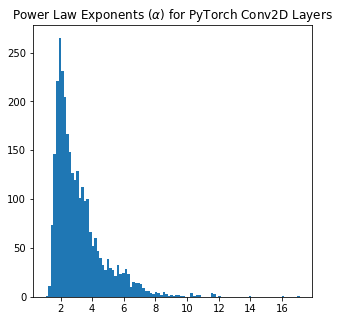

In [13]:
plt.hist(all_alphas,bins=100);
plt.title(r"Power Law Exponents ($\alpha$) for PyTorch Conv2D Layers")
plt.show()

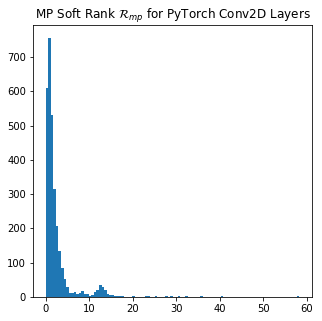

In [14]:
plt.hist(all_ranks,bins=100);
plt.title(r"MP Soft Rank $\mathcal{R}_{mp}$ for PyTorch Conv2D Layers")
plt.show()

In [15]:
aa = np.array(all_alphas)

In [16]:
len(aa), len(aa[aa<5])

(2971, 2595)

In [17]:
100.0*len(aa[aa<5])/len(aa), 100.0*len(aa[aa<4])/len(aa),  100.0*len(aa[aa<1.5])/len(aa)

(87.34432850891956, 78.55940760686637, 1.682935038707506)

### Rank Loss

...only ~ 300/3000 ~ %13

This is hard to see in the plot

It may be easier to see on a log plot

In [63]:
ms = np.array(all_min_svs)
len(ms[ms<0.00001]), len(ms), 100.0*len(ms[ms<0.00001])/len(ms)

(393, 2971, 13.227869404240996)

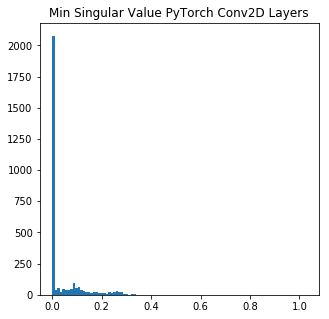

In [62]:
plt.hist(all_min_svs,bins=100);
plt.title(r"Min Singular Value PyTorch Conv2D Layers")
plt.show()

### Log Scale on Min Values

#TODO:  remove Q=1 cases

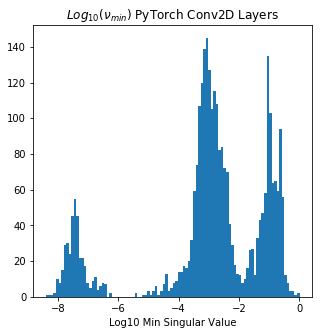

In [80]:
lm = np.log10(all_min_svs)
plt.hist(lm,bins=100);
plt.title(r"$Log_{10}(\nu_{min})$ PyTorch Conv2D Layers")
plt.xlabel("Log10 Min Singular Value")
plt.savefig("img/log-min-nu-pytorch-conv2d")
plt.show()


In [66]:
len(lm[lm<-6]), len(lm)

(387, 2971)